<a href="https://colab.research.google.com/github/valenottaviano/Confidence-Interval-Inference/blob/main/Confidence_Interval_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.autograph.set_verbosity(0)

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv', index_col='Month')
series = df['Sales'].values
series.shape = (series.shape[0],1)

In [5]:
from numpy import array

def split_dataset(data):
    # split into standard weeks
    train, test = data[:-12], data[-12:]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/3))
    test = np.array(np.split(test, len(test)/3))
    return train, test

def to_supervised(train, n_input, n_out):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [10]:
train, test = split_dataset(series)
output_shape = 3
input_shape = 6

train_X, train_y = to_supervised(train, input_shape, output_shape)
test_X, test_y = to_supervised(test, input_shape, output_shape)


for i in range(train_X.shape[0]):
  print(train_X[i].flatten(), train_y[i])

[266.  145.9 183.1 119.3 180.3 168.5] [231.8 224.5 192.8]
[145.9 183.1 119.3 180.3 168.5 231.8] [224.5 192.8 122.9]
[183.1 119.3 180.3 168.5 231.8 224.5] [192.8 122.9 336.5]
[119.3 180.3 168.5 231.8 224.5 192.8] [122.9 336.5 185.9]
[180.3 168.5 231.8 224.5 192.8 122.9] [336.5 185.9 194.3]
[168.5 231.8 224.5 192.8 122.9 336.5] [185.9 194.3 149.5]
[231.8 224.5 192.8 122.9 336.5 185.9] [194.3 149.5 210.1]
[224.5 192.8 122.9 336.5 185.9 194.3] [149.5 210.1 273.3]
[192.8 122.9 336.5 185.9 194.3 149.5] [210.1 273.3 191.4]
[122.9 336.5 185.9 194.3 149.5 210.1] [273.3 191.4 287. ]
[336.5 185.9 194.3 149.5 210.1 273.3] [191.4 287.  226. ]
[185.9 194.3 149.5 210.1 273.3 191.4] [287.  226.  303.6]
[194.3 149.5 210.1 273.3 191.4 287. ] [226.  303.6 289.9]
[149.5 210.1 273.3 191.4 287.  226. ] [303.6 289.9 421.6]
[210.1 273.3 191.4 287.  226.  303.6] [289.9 421.6 264.5]


In [12]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional, Flatten

# define parameters
verbose, epochs, batch_size = 1, 100, 3
n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]


# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True)))
model.add(Dense(200, activation='relu'))
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)


4/4 [==============================] - 0s 45ms/step - loss: 3540.0098 - val_loss: 10820.5537
Epoch 83/100
4/4 [==============================] - 0s 47ms/step - loss: 3807.1921 - val_loss: 15567.5088
Epoch 84/100
4/4 [==============================] - 0s 42ms/step - loss: 3071.7859 - val_loss: 14209.1328
Epoch 85/100
4/4 [==============================] - 0s 44ms/step - loss: 3111.6309 - val_loss: 8888.0195
Epoch 86/100
4/4 [==============================] - 0s 46ms/step - loss: 2885.0840 - val_loss: 6544.0122
Epoch 87/100
4/4 [==============================] - 0s 46ms/step - loss: 2959.0898 - val_loss: 9295.7197
Epoch 88/100
4/4 [==============================] - 0s 46ms/step - loss: 4431.8862 - val_loss: 6386.0586
Epoch 89/100
4/4 [==============================] - 0s 44ms/step - loss: 2877.2383 - val_loss: 6235.2456
Epoch 90/100
4/4 [==============================] - 0s 44ms/step - loss: 4282.1733 - val_loss: 12585.9482
Epoch 91/100
4/4 [==============================] - 0s 43ms/step

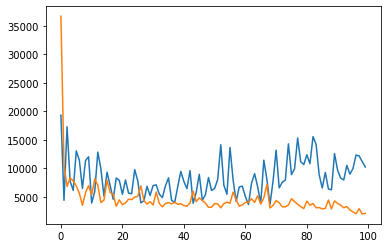

In [14]:
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error

def fit_model(X_train, y_train):
	# define parameters
  verbose, epochs, batch_size = 0, 50, 3
  n_timesteps, n_features, n_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]


  # define model
  model = Sequential()
  model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True)))
  model.add(Dense(200, activation='relu'))
  model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
  model.add(Dropout(0.4))
  model.add(Dense(n_outputs))
  model.compile(loss='mse', optimizer='adam')

  # fit network
  model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
  return model

# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
	ensemble = list()
	for i in range(n_members):
		# define and fit the model on the training set
		model = fit_model(X_train, y_train)
		# evaluate model on the test set
		yhat = model.predict(X_test)
		mae = mean_absolute_error(y_test, yhat)
		# store the model
		ensemble.append(model)
	return ensemble

n_members = 10
ensemble = fit_ensemble(n_members, train_X, test_X, train_y, test_y)

In [26]:
# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X):
	# make predictions
	yhat = [model.predict(X, verbose=0) for model in ensemble]
	yhat = np.asarray(yhat)
	# calculate 95% gaussian prediction interval
	interval = 1.96 * yhat.std()
	lower, upper = yhat.mean() - interval, yhat.mean() + interval
	return lower, yhat.mean(), upper


In [27]:
y_hats = []
for model in ensemble:
  pred = model.predict(test_X[0].reshape(1,input_shape,1))
  y_hats.append(pred)

predictions = []
means, stds, lowers, uppers = [], [], [], []

for i in range(output_shape):
  mean = np.asarray(y_hats)[:,0,i].mean()
  std = np.asarray(y_hats)[:,0,i].std()
  interval = 1.96 * std

  predictions.append((
      mean,
      std,
      mean + interval,
      mean - interval))


In [28]:
pred_df = pd.DataFrame(data=predictions, columns=['mean', 'std', 'upper', 'lower'])

In [31]:
pred_df['actual'] = test_y[0]

In [32]:
pred_df

,mean,std,upper,lower,actual
0,478.112976,60.766045,597.214424,359.011529,575.5
1,456.600586,49.900589,554.405740,358.795432,407.6
2,495.069031,27.743580,549.446447,440.691614,682.0


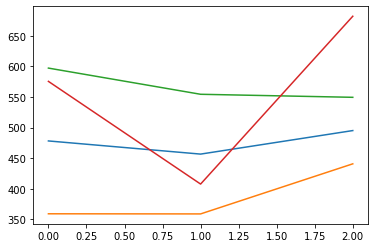

In [37]:
# plt.fill_between(pred_df['mean'], pred_df['lower'], pred_df['upper'])
plt.plot(pred_df['mean'])
plt.plot(pred_df['lower'])
plt.plot(pred_df['upper'])
plt.plot(pred_df['actual'])
